In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

#libraries to conect to centralised pool of info
import datetime as dt
#from PyQuantimClient.portfolios import portfolios
#from PyQuantimClient.data import time_series


plt.style.use ('ggplot')

pd.options.display.float_format = '{:,.4f}'.format

In [2]:
# setup params for brownian motion
s0 = 190_000.00
sigma = 0.09
# mod = 0.095

mu = 0.068
# setup the simulation
paths = 1_000
delta = 1.0/252.0
time = 252 * 20

### Functions

In [3]:
def wiener_process(delta, sigma, time, paths):
    """Returns a Wiener process
    
    Parameters
    ----------
    delta : float
        The increment to downsample sigma
    sigma : float
        Percentage volatility
    time : int
        Number of samples to create
    paths : int
        Number of price simulations to create
    
    Returns
    -------
    wiener_process : np.ndarray
    
    Notes
    -----
    This method returns a Wiener process. 
    The Wiener process is also called Brownian 
    motion. For more information about the 
    Wiener process check out the Wikipedia 
    page: http://en.wikipedia.org/wiki/Wiener_process
    """
    # return an array of samples from a normal distribution
    return sigma * np.random.normal(loc=0, scale=np.sqrt(delta), size=(time, paths))

In [4]:
def gbm_returns(delta, sigma, time, mu, paths):
    """Returns from a Geometric brownian motion
    
    Parameters
    ----------
    delta : float
        The increment to downsample sigma
    sigma : float
        Percentage volatility
    time : int
        Number of samples to create
    mu : float
        Percentage drift
    paths : int
        Number of price simulations to create
    
    Returns
    -------
    gbm_returns : np.ndarray
    
    Notes
    -----
    This method constructs random Geometric Brownian 
    Motion (GBM).
    """
    process = wiener_process(delta, sigma, time, paths)
    return np.exp(process + (mu - sigma**2 / 2) * delta)

In [5]:
def gbm_levels(s0, delta, sigma, time, mu, paths):
    """Returns price paths starting at s0
    
    Parameters
    ----------
    s0 : float
        The starting stock price
    delta : float
        The increment to downsample sigma
    sigma : float
        Percentage volatility
    time : int
        Number of samples to create
    mu : float
        Percentage drift
    paths : int
        Number of price simulations to create
    
    Returns
    -------
    gbm_levels : np.ndarray
    """
    returns = gbm_returns(delta, sigma, time, mu, paths)
    stacked = np.vstack([np.ones(paths), returns])
    return s0 * stacked.cumprod(axis=0)

### Simulation with in/outflows 

In [6]:
l = gbm_levels(1, delta, sigma, time, mu, paths)

In [7]:
df_l = pd.DataFrame(l)
df_r = df_l/df_l.shift(1)

# finding lowest and highest port ending value
max_l = df_l.apply(np.max,axis=1).iloc[-1]
avg_l = df_l.iloc[-1].sort_values().iloc[int(np.round(paths/2))]
#avg_l = np.quantile(df_l.iloc[-1],.5)
min_l = df_l.apply(np.min,axis=1).iloc[-1]

# finding lowest and highest path index
max_idx = np.where(df_l == max_l)[1].item()
avg_idx = np.where(df_l == avg_l)[1].item()
min_idx = np.where(df_l == min_l)[1].item()

In [8]:
avg_idx

274

In [9]:
max_idx

111

In [10]:
min_idx

436

In [11]:
df_maxport = pd.DataFrame(np.zeros([df_r.index[-1],6]),columns=['bop_cap','inflow','outflow','$_return','%_return','eop_cap'])
df_avgport = pd.DataFrame(np.zeros([df_r.index[-1],6]),columns=['bop_cap','inflow','outflow','$_return','%_return','eop_cap'])
df_minport = pd.DataFrame(np.zeros([df_r.index[-1],6]),columns=['bop_cap','inflow','outflow','$_return','%_return','eop_cap'])

In [12]:
df_maxport['%_return'] = df_r.iloc[:,max_idx].fillna(1)-1
df_avgport['%_return'] = df_r.iloc[:,avg_idx].fillna(1)-1
df_minport['%_return'] = df_r.iloc[:,min_idx].fillna(1)-1


In [13]:
inflows_idx = df_maxport.index[df_maxport.index % 252 == 0]

In [14]:
inflow = 1_000

df_maxport.loc[inflows_idx,'inflow'] = inflow
df_maxport.loc[0,'inflow'] = 0
df_minport.loc[inflows_idx,'inflow'] = inflow
df_minport.loc[0,'inflow'] = 0
df_avgport.loc[inflows_idx,'inflow'] = inflow
df_avgport.loc[0,'inflow'] = 0

In [15]:
outflows_idx = df_maxport.index[df_maxport.index % 42 == 0]

In [16]:
outflow = -0_000

df_maxport.loc[outflows_idx,'outflow'] = outflow
df_maxport.loc[0,'outflow'] = 0

df_avgport.loc[outflows_idx,'outflow'] = outflow
df_avgport.loc[0,'outflow'] = 0

df_minport.loc[outflows_idx,'outflow'] = outflow
df_minport.loc[0,'outflow'] = 0

In [17]:
df_maxport['$_return'] = df_maxport['bop_cap']*df_maxport['%_return']
df_avgport['$_return'] = df_maxport['bop_cap']*df_maxport['%_return']
df_minport['$_return'] = df_minport['bop_cap']*df_minport['%_return']

In [18]:
def capital_calculation(df):
    for idx,_ in df.iterrows():
        
        #df.loc[idx,'$_return'] = df.loc[idx,'bop_cap']*df.loc[idx,'%_return']
        #df.loc[idx,'eop_cap'] = np.max(0,df.loc[idx,'bop_cap']+df.loc[idx,'inflow']+df.loc[idx,'outflow']+df.loc[idx,'$_return'])
        
        if idx == 0:
            df.loc[idx,'bop_cap'] = s0
            df.loc[idx,'eop_cap'] = df.loc[idx,'bop_cap']
        else:
            df.loc[idx,'bop_cap'] = df.loc[idx-1,'eop_cap'] 
            df.loc[idx,'$_return'] = df.loc[idx,'bop_cap']*df.loc[idx,'%_return']
            df.loc[idx,'eop_cap'] = np.max(df.loc[idx,'bop_cap']+df.loc[idx,'inflow']+df.loc[idx,'outflow']+df.loc[idx,'$_return'])
        
    return df

In [19]:
df_maxport = capital_calculation(df_maxport)
df_maxport

,bop_cap,inflow,outflow,$_return,%_return,eop_cap
0,"190,000.0000",0.0000,0.0000,0.0000,0.0000,"190,000.0000"
1,"190,000.0000",0.0000,0.0000,151.1893,0.0008,"190,151.1893"
2,"190,151.1893",0.0000,0.0000,-613.9344,-0.0032,"189,537.2550"
3,"189,537.2550",0.0000,0.0000,535.6953,0.0028,"190,072.9503"
4,"190,072.9503",0.0000,0.0000,"1,963.1360",0.0103,"192,036.0863"
...,...,...,...,...,...,...
5035,"2,582,069.1370",0.0000,0.0000,"11,006.4201",0.0043,"2,593,075.5572"
5036,"2,593,075.5572",0.0000,0.0000,"-14,375.2467",-0.0055,"2,578,700.3105"
5037,"2,578,700.3105",0.0000,0.0000,"19,498.5324",0.0076,"2,598,198.8429"
5038,"2,598,198.8429",0.0000,0.0000,414.5414,0.0002,"2,598,613.3843"


In [20]:
df_avgport = capital_calculation(df_avgport)
df_avgport

,bop_cap,inflow,outflow,$_return,%_return,eop_cap
0,"190,000.0000",0.0000,0.0000,0.0000,0.0000,"190,000.0000"
1,"190,000.0000",0.0000,0.0000,-973.0760,-0.0051,"189,026.9240"
2,"189,026.9240",0.0000,0.0000,41.5265,0.0002,"189,068.4505"
3,"189,068.4505",0.0000,0.0000,543.4010,0.0029,"189,611.8516"
4,"189,611.8516",0.0000,0.0000,"1,014.9710",0.0054,"190,626.8225"
...,...,...,...,...,...,...
5035,"726,598.2255",0.0000,0.0000,"2,012.7011",0.0028,"728,610.9266"
5036,"728,610.9266",0.0000,0.0000,-147.0691,-0.0002,"728,463.8575"
5037,"728,463.8575",0.0000,0.0000,"-3,703.8435",-0.0051,"724,760.0140"
5038,"724,760.0140",0.0000,0.0000,"-4,681.4873",-0.0065,"720,078.5267"


In [21]:
df_minport = capital_calculation(df_minport)
df_minport

,bop_cap,inflow,outflow,$_return,%_return,eop_cap
0,"190,000.0000",0.0000,0.0000,0.0000,0.0000,"190,000.0000"
1,"190,000.0000",0.0000,0.0000,-231.0832,-0.0012,"189,768.9168"
2,"189,768.9168",0.0000,0.0000,71.6239,0.0004,"189,840.5407"
3,"189,840.5407",0.0000,0.0000,"-1,046.9594",-0.0055,"188,793.5813"
4,"188,793.5813",0.0000,0.0000,-987.7964,-0.0052,"187,805.7849"
...,...,...,...,...,...,...
5035,"212,007.5717",0.0000,0.0000,-512.5618,-0.0024,"211,495.0100"
5036,"211,495.0100",0.0000,0.0000,-306.1613,-0.0014,"211,188.8487"
5037,"211,188.8487",0.0000,0.0000,-884.8195,-0.0042,"210,304.0293"
5038,"210,304.0293",0.0000,0.0000,"1,265.5589",0.0060,"211,569.5882"


<Axes: >

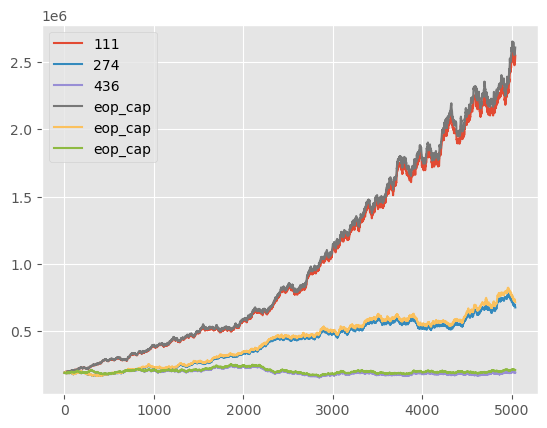

In [22]:
(s0*df_l.loc[:,max_idx]).plot(legend=True)
(s0*df_l.loc[:,avg_idx]).plot(legend=True)
(s0*df_l.loc[:,min_idx]).plot(legend=True)

df_maxport['eop_cap'].plot(legend=True)
df_avgport['eop_cap'].plot(legend=True)
df_minport['eop_cap'].plot(legend=True)

In [23]:
pd.Series(df_minport.iloc[-1]['eop_cap'])

0   210,994.0187
dtype: float64

In [55]:
pd.Series(df_avgport.iloc[-1]['eop_cap'])

0   715,512.7939
dtype: float64

In [24]:
pd.Series(df_maxport.iloc[-1]['eop_cap'])

0   2,608,747.6555
dtype: float64

### US historical CPI series

In [25]:
cpi_series = pd.read_csv('CPIAUCSL.csv', index_col=0, parse_dates=True)

<Axes: xlabel='DATE'>

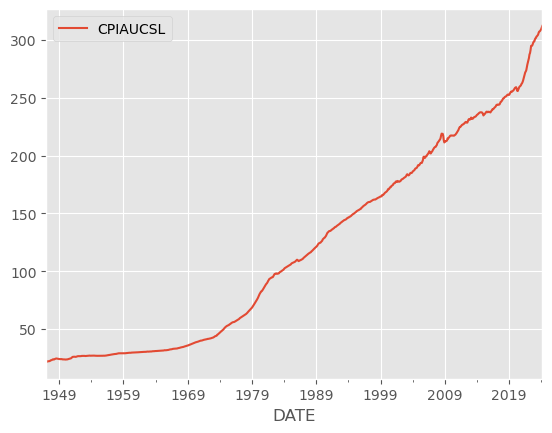

In [26]:
cpi_series.plot()

In [27]:
cpi_series/ cpi_series.shift(30*12) -1

,CPIAUCSL
DATE,
1947-01-01,NaN
1947-02-01,NaN
1947-03-01,NaN
1947-04-01,NaN
1947-05-01,NaN
...,...
2023-11-01,1.1098
2023-12-01,1.1103
2024-01-01,1.1168


In [28]:
cpi_series.iloc[-1]/cpi_series.iloc[0]

CPIAUCSL   14.5358
dtype: float64

In [29]:
mean_cpi_us = ((cpi_series.iloc[-1]/cpi_series.iloc[0])**(12/len(cpi_series))-1)*100
mean_cpi_us = mean_cpi_us.item()

In [30]:
mean_cpi_us

3.525603656449361

In [31]:
colors = ['#7A6855','#768692','#A6B0B8']

In [32]:
rolling_30yr_cpi = 100*(cpi_series.pct_change(30*12)**(1/30)-1)
rolling_30yr_cpi.dropna(inplace=True)

Text(0.5, 1.0, 'Hist annual mean CPI')

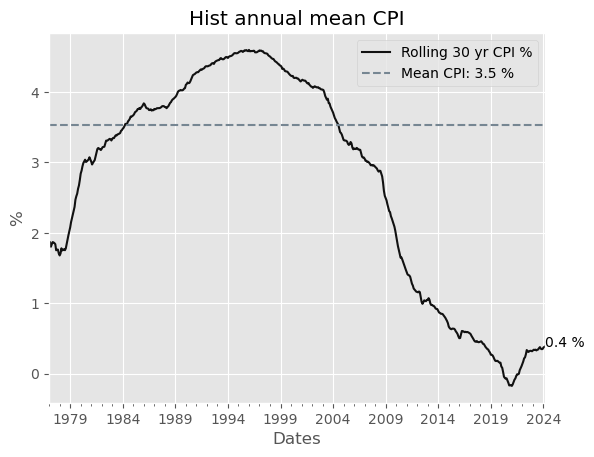

In [33]:
rolling_30yr_cpi.plot(color = '#111111')
plt.axhline(mean_cpi_us,linestyle='--', color =colors[1])
plt.legend([f'Rolling 30 yr CPI %',f'Mean CPI: {mean_cpi_us:,.1f} %'])
plt.text(rolling_30yr_cpi.index[-1],rolling_30yr_cpi.iloc[-1], f'{rolling_30yr_cpi.iloc[-1].item():,.1f} %')
plt.ylabel('%');
plt.xlabel('Dates');
plt.title('Hist annual mean CPI')

In [34]:
rolling_30yr_cpi.tail()

,CPIAUCSL
DATE,
2023-11-01,0.3477
2023-12-01,0.3495
2024-01-01,0.3688
2024-02-01,0.3795
2024-03-01,0.3861


<Axes: xlabel='DATE'>

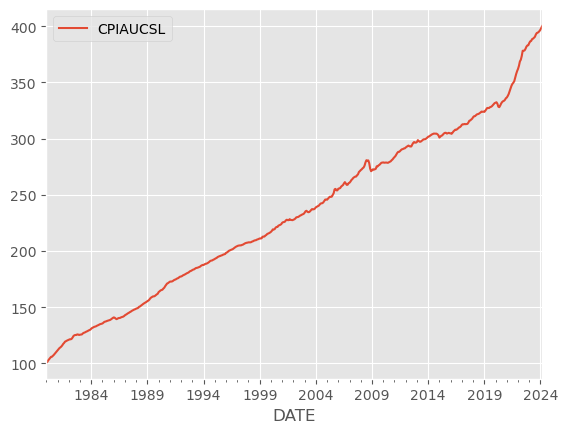

In [35]:
((1+cpi_series.loc['1980':].pct_change()).cumprod()*100).plot()

### Portfolio Sim

In [36]:
price_paths = gbm_levels(s0, delta, sigma, time, mu, paths)

In [37]:
dt.datetime.today() 

datetime.datetime(2024, 5, 20, 10, 35, 57, 930552)

In [38]:
time_index = pd.bdate_range(dt.datetime.today(),freq='B',periods=time+1)

In [39]:
time_index[-1]

Timestamp('2043-09-14 00:00:00', freq='B')

C:\Users\luis.gaitan\AppData\Local\Temp\ipykernel_8788\2243541721.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values]);


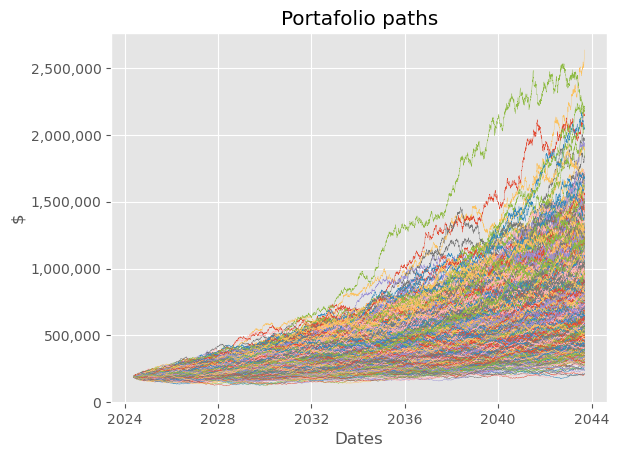

In [40]:

plt.plot(time_index,price_paths, linewidth=0.25)
# formating y axis
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values]);
# adding title and axis names
plt.xlabel('Dates');
plt.ylabel('$');
plt.title('Portafolio paths');
#plt.figure(figsize=(18,6));
plt.show()

In [41]:
best_path = price_paths.max(axis=1)
best_cagr = ((best_path[-1]/s0)**(252/time)-1)*100

In [42]:
best_cagr

14.056532120185384

In [43]:
worst_path = price_paths.min(axis=1)
worst_cagr = ((worst_path[-1]/s0)**(252/time)-1)*100

In [44]:
worst_cagr

0.3838595092228836

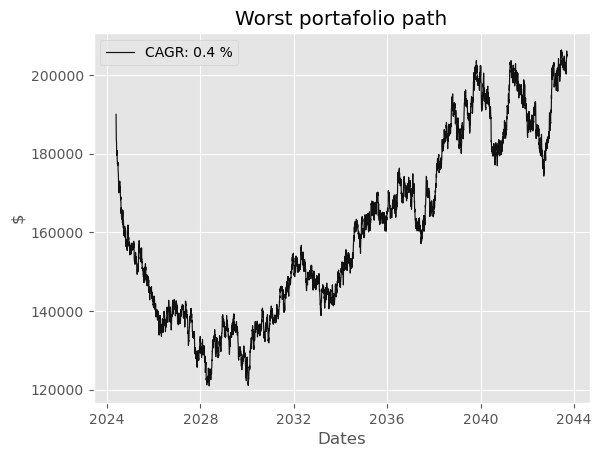

In [45]:
plt.plot(time_index, worst_path, color='#111111', linewidth=0.85)
#plt.plot(time_index,best_path)
# adding title and axis names
plt.xlabel('Dates');
plt.ylabel('$');
plt.title('Worst portafolio path');
# Add legen names and values
plt.legend([f'CAGR: {worst_cagr:,.1f} %'])
#plt.figure(figsize=(18,6));
plt.show()

In [46]:
end_val = price_paths[-1]

q10 = np.quantile(price_paths[-1],0.10)
q90 = np.quantile(price_paths[-1],0.90)
me = np.mean(price_paths[-1])
xcoords = [q10,me,q90]
colors = ['#7A6855','#768692','#A6B0B8']

C:\Users\luis.gaitan\AppData\Local\Temp\ipykernel_8788\4166114863.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values]);


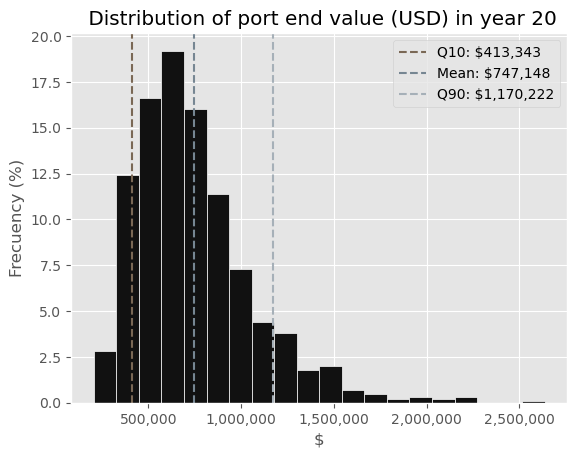

In [47]:
# Hist plot, color = '#B9BBBE'
plt.hist(price_paths[-1],weights=(np.zeros_like(end_val) + 1. / end_val.size)*100, bins=20, edgecolor='white', color='#111111')
plt.xlabel(f'$')
plt.ylabel('Frecuency (%)')
plt.title(f' Distribution of port end value (USD) in year {time/252:,.0f}')
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values]);


for idx, i in enumerate(xcoords):
    plt.axvline(x=xcoords[idx] , color = colors[idx], linestyle='--')


# Add legen names and values
plt.legend([f'Q10: ${q10:,.0f}',f'Mean: ${me:,.0f}',f'Q90: ${q90:,.0f}'])
# Q10, color = '#59646E'



In [48]:
ann_ret_y30 = ((price_paths[-1]/s0)**(252/time)-1)*100

In [49]:
q10 = np.quantile(ann_ret_y30,0.10)
q90 = np.quantile(ann_ret_y30,0.90)
me = np.mean(ann_ret_y30)
xcoords = [q10,me,q90]

colors = ['#7A6855','#768692','#A6B0B8']

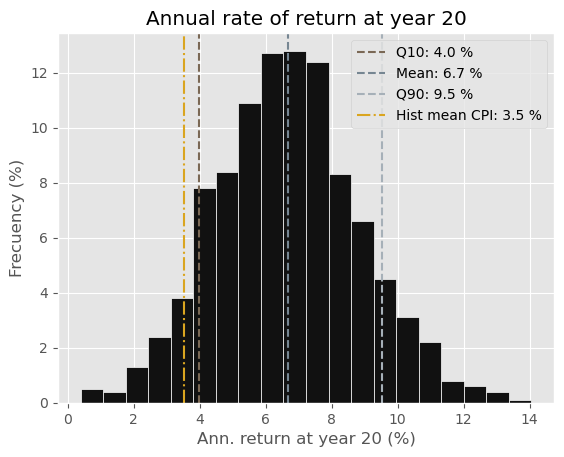

In [50]:
plt.hist(ann_ret_y30,weights=(np.zeros_like(ann_ret_y30) + 1. / ann_ret_y30.size)*100, bins=20, edgecolor='white', color='#111111')
plt.xlabel(f'Ann. return at year {time/252:,.0f} (%)')
plt.ylabel('Frecuency (%)')
plt.title(f'Annual rate of return at year {time/252:,.0f}')

for idx, i in enumerate(xcoords):
    plt.axvline(x=xcoords[idx] , color = colors[idx], linestyle='--')

# add annual hist mean cpi 
plt.axvline(x=mean_cpi_us , color = 'goldenrod' , linestyle='-.')
   
# Add legen names and values
plt.legend([f'Q10: {q10:,.1f} %',f'Mean: {me:,.1f} %',f'Q90: {q90:,.1f} %',f'Hist mean CPI: {mean_cpi_us:,.1f} %'])#,loc='center left', bbox_to_anchor=(0.7, 0.5), ncol= 1)
    
#plt.legend()

In [51]:
# prob of retunr higher than threshold
len(ann_ret_y30[ann_ret_y30 > mean_cpi_us])/10

93.9

In [52]:
len(price_paths[-1, price_paths[-1, :] > s0])

1000

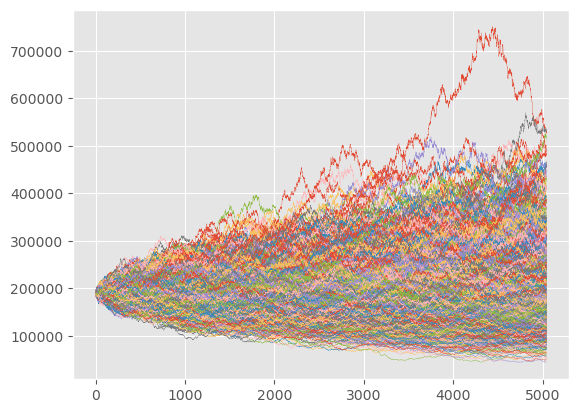

In [53]:
price_paths = gbm_levels(s0, delta, sigma, time, 0.0, paths)
plt.plot(price_paths, linewidth=0.25)
plt.show()

In [54]:
len(price_paths[-1, price_paths[-1, :] > s0])

404